# Spherical Fourier Neural Operators

A simple notebook to showcase spherical Fourier Neural Operators


## Preparation

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.cuda import amp
from torch.optim.lr_scheduler import OneCycleLR

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from math import ceil, sqrt

import time

cmap='twilight_shifted'

In [2]:
enable_amp = False

# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(device.index)

### Training data
to train our geometric FNOs, we require training data. To this end let us prepare a Dataloader which computes results on the fly:

In [3]:
# dataset
from torch_harmonics.examples import PdeDataset
from torch_harmonics.examples.models import SphericalFourierNeuralOperator, LocalSphericalNeuralOperator, SphericalTransformer

# 1 hour prediction steps
dt = 1*1800
dt_solver = 100
nsteps = dt//dt_solver
grid = "equiangular"
dataset = PdeDataset(dt=dt, nsteps=nsteps, dims=(241, 480), device=device, normalize=True, grid=grid)
# There is still an issue with parallel dataloading. Do NOT use it at the moment
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, persistent_workers=False)
solver = dataset.solver.to(device)

nlat = dataset.nlat
nlon = dataset.nlon

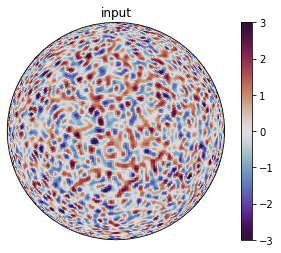

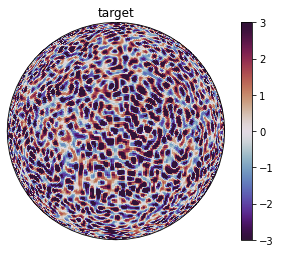

In [4]:
torch.manual_seed(0)
inp, tar = dataset[0]

fig = plt.figure()
im = solver.plot_griddata(inp[2], fig, vmax=3, vmin=-3)
plt.title("input")
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = solver.plot_griddata(tar[2], fig, vmax=3, vmin=-3)
plt.title("target")
plt.colorbar(im)
plt.show()

### Defining the Spherical Neural Operator

In [5]:
model = SphericalFourierNeuralOperator(img_size=(nlat, nlon), grid=grid, num_layers=4, scale_factor=3, embed_dim=16, residual_prediction=True, pos_embed="spectral", use_mlp=True, normalization_layer="none").to(device)


## Training the model

In [6]:
def l2loss_sphere(solver, prd, tar, relative=False, squared=True):
    loss = solver.integrate_grid((prd - tar)**2, dimensionless=True).sum(dim=-1)
    if relative:
        loss = loss / solver.integrate_grid(tar**2, dimensionless=True).sum(dim=-1)

    if not squared:
        loss = torch.sqrt(loss)
    loss = loss.mean()

    return loss

def spectral_l2loss_sphere(solver, prd, tar, relative=False, squared=True):
    # compute coefficients
    coeffs = torch.view_as_real(solver.sht(prd - tar))
    coeffs = coeffs[..., 0]**2 + coeffs[..., 1]**2
    norm2 = coeffs[..., :, 0] + 2 * torch.sum(coeffs[..., :, 1:], dim=-1)
    loss = torch.sum(norm2, dim=(-1,-2))

    if relative:
        tar_coeffs = torch.view_as_real(solver.sht(tar))
        tar_coeffs = tar_coeffs[..., 0]**2 + tar_coeffs[..., 1]**2
        tar_norm2 = tar_coeffs[..., :, 0] + 2 * torch.sum(tar_coeffs[..., :, 1:], dim=-1)
        tar_norm2 = torch.sum(tar_norm2, dim=(-1,-2))
        loss = loss / tar_norm2

    if not squared:
        loss = torch.sqrt(loss)
    loss = loss.mean()

    return loss

In [7]:
# training function
def train_model(model, dataloader, optimizer, scheduler=None, nepochs=20, nfuture=0, num_examples=256, num_valid=8, loss_fn='l2'):

    train_start = time.time()

    for epoch in range(nepochs):

        # time each epoch
        epoch_start = time.time()

        dataloader.dataset.set_initial_condition('random')
        dataloader.dataset.set_num_examples(num_examples)

        optimizer.zero_grad(set_to_none=True)

        # do the training
        acc_loss = 0
        model.train()
        for inp, tar in dataloader:
            with amp.autocast(enabled=enable_amp):
                prd = model(inp)
                for _ in range(nfuture):
                    prd = model(prd)
                if loss_fn == 'l2':
                    loss = l2loss_sphere(solver, prd, tar)
                elif loss_fn == "spectral l2":
                    loss = spectral_l2loss_sphere(solver, prd, tar)

            acc_loss += loss.item() * inp.size(0)

            optimizer.zero_grad(set_to_none=True)
            # gscaler.scale(loss).backward()
            loss.backward()
            optimizer.step()
            # gscaler.update()

        if scheduler is not None:
            scheduler.step()

        acc_loss = acc_loss / len(dataloader.dataset)

        dataloader.dataset.set_initial_condition('random')
        dataloader.dataset.set_num_examples(num_valid)

        # perform validation
        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for inp, tar in dataloader:
                prd = model(inp)
                for _ in range(nfuture):
                    prd = model(prd)
                loss = l2loss_sphere(solver, prd, tar, relative=True)

                valid_loss += loss.item() * inp.size(0)

        valid_loss = valid_loss / len(dataloader.dataset)

        epoch_time = time.time() - epoch_start

        print(f'--------------------------------------------------------------------------------')
        print(f'Epoch {epoch} summary:')
        print(f'time taken: {epoch_time}')
        print(f'accumulated training loss: {acc_loss}')
        print(f'relative validation loss: {valid_loss}')

    train_time = time.time() - train_start

    print(f'--------------------------------------------------------------------------------')
    print(f'done. Training took {train_time}.')
    return valid_loss

In [8]:
# set seed
torch.manual_seed(333)
torch.cuda.manual_seed(333)

optimizer = torch.optim.Adam(model.parameters(), lr=3E-3, weight_decay=0.0)
gscaler = amp.GradScaler(enabled=enable_amp)
train_model(model, dataloader, optimizer, nepochs=10)

# multistep training
# learning_rate = 5e-4
# optimizer = torch.optim.Adam(fno_model.parameters(), lr=learning_rate)
# dataloader.dataset.nsteps = 2 * dt//dt_solver
# train_model(fno_model, dataloader, optimizer, nepochs=10, nfuture=1)
# dataloader.dataset.nsteps = 1 * dt//dt_solver

/tmp/ipykernel_1169109/452377886.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  gscaler = amp.GradScaler(enabled=enable_amp)
/tmp/ipykernel_1169109/3394806124.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=enable_amp):


--------------------------------------------------------------------------------
Epoch 0 summary:
time taken: 11.15151309967041
accumulated training loss: 159.13087838888168
relative validation loss: 0.45184075832366943
--------------------------------------------------------------------------------
Epoch 1 summary:
time taken: 11.065720558166504
accumulated training loss: 22.263614624738693
relative validation loss: 0.21920078992843628
--------------------------------------------------------------------------------
Epoch 2 summary:
time taken: 11.02693772315979
accumulated training loss: 12.307873576879501
relative validation loss: 0.13958265632390976
--------------------------------------------------------------------------------
Epoch 3 summary:
time taken: 10.793971300125122
accumulated training loss: 8.512125879526138
relative validation loss: 0.10448098555207253
--------------------------------------------------------------------------------
Epoch 4 summary:
time taken: 11.012253

0.05719645507633686

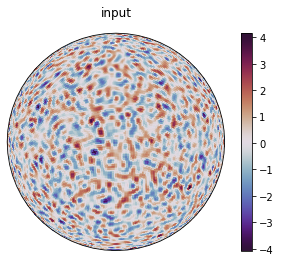

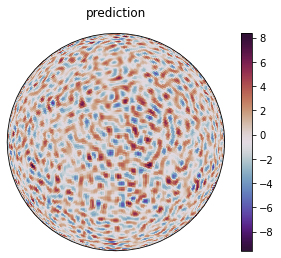

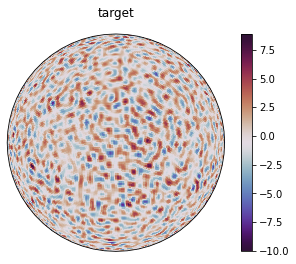

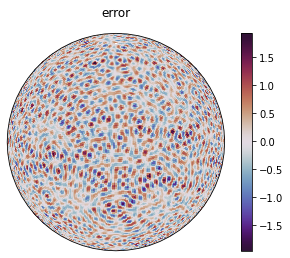

In [9]:
dataloader.dataset.set_initial_condition('random')

torch.manual_seed(0)

with torch.inference_mode():
    inp, tar = next(iter(dataloader))
    out = model(inp).detach()

s = 0; ch = 2

fig = plt.figure()
im = solver.plot_griddata(inp[s, ch], fig, projection='3d', title='input')
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = solver.plot_griddata(out[s, ch], fig, projection='3d', title='prediction')
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = solver.plot_griddata(tar[s, ch], fig, projection='3d', title='target')
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = solver.plot_griddata((tar-out)[s, ch], fig, projection='3d', title='error')
plt.colorbar(im)
plt.show()